In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

## Fetching tweets using snscrape

In [2]:
import snscrape.modules.twitter as sntwitter

Released on July 8, 2020, snscrape is a scraping tool for social networking services (SNS). It scrapes things like users, user profiles, hashtags, searches, threads, list posts and returns the discovered items without using Twitter’s API.

Interestingly, snscrape is not just for scraping tweets but also across various other social networking sites like Facebook, Instagram, Reddit, VKontakte, and Weibo (Sina Weibo).

how to use : https://medium.com/dataseries/how-to-scrape-millions-of-tweets-using-snscrape-195ee3594721

In [3]:
# Creating list to append tweet data to
tweets_list = []

# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('kanye west is').get_items()):
    if i>5000:
        break
    tweets_list.append(tweet.content)
    
# Creating a dataframe from the tweets list above
tweets_df = pd.DataFrame(tweets_list, columns=['Text'])

In [4]:
tweets_df.head()

,Text
0,@Leavebeansalone @TheScarletGold1 @WandaSuprem...
1,😂😂😂😂😂Lmao Kanye West is hilarious man
2,@Strange_Dream7 @TheScarletGold1 @WandaSuprema...
3,Kris Jenner Is Apparently “Sick And Tired” Of ...
4,Kris Jenner Is Apparently “Sick And Tired” Of ...


In [5]:
tweets_df.shape

(5001, 1)

### Fetching sentiments

we will be using nltk SentimentIntensityAnalyzer
NLP: How does NLTK.Vader Calculate Sentiment? https://medium.com/@mystery0116/nlp-how-does-nltk-vader-calculate-sentiment-6c32d0f5046b

In [6]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [7]:
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'


In [8]:
sentiments_using_SIA = tweets_df.Text.apply(lambda tweet: fetch_sentiment_using_SIA(tweet))
pd.DataFrame(sentiments_using_SIA.value_counts())

,Text
pos,3392
neg,1609


In [9]:
tweets_df.isnull().sum()

Text    0
dtype: int64

In [10]:
tweets_df['sentiment'] = sentiments_using_SIA
tweets_df.head()

,Text,sentiment
0,@Leavebeansalone @TheScarletGold1 @WandaSuprem...,pos
1,😂😂😂😂😂Lmao Kanye West is hilarious man,pos
2,@Strange_Dream7 @TheScarletGold1 @WandaSuprema...,neg
3,Kris Jenner Is Apparently “Sick And Tired” Of ...,pos
4,Kris Jenner Is Apparently “Sick And Tired” Of ...,pos


## Text pre-processing "key words"

In [11]:
import re
# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('brown')
stopwords = set(stopwords.words("english"))
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.porter import *
from textblob.sentiments import NaiveBayesAnalyzer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Removing @username

Since the user who tweeted or retweeted the tweet is not important we'll remove them

In [12]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i,'', text)
    
    return text 

In [13]:
tweets_df['Clean_text'] = np.vectorize(remove_pattern)(tweets_df['Text'], "@[\w]*: | *RT*")
tweets_df['Clean_text'] = np.vectorize(remove_pattern)(tweets_df['Text'], "@(?i)[a-z0-9_]+")

tweets_df.head(3)

/tmp/ipykernel_1863/2534684602.py:2: DeprecationWarning: Flags not at the start of the expression '@(?i)[a-z0-9_]+' but at position 1
  r = re.findall(pattern_regex, text)


,Text,sentiment,Clean_text
0,@Leavebeansalone @TheScarletGold1 @WandaSuprem...,pos,Why is Peta coming in? Is this ...
1,😂😂😂😂😂Lmao Kanye West is hilarious man,pos,😂😂😂😂😂Lmao Kanye West is hilarious man
2,@Strange_Dream7 @TheScarletGold1 @WandaSuprema...,neg,this is getting rly bad you ne...


### Removing links

In [14]:
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.Clean_text.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweets_df['Clean_text'] = cleaned_tweets
tweets_df.head(3)

,Text,sentiment,Clean_text
0,@Leavebeansalone @TheScarletGold1 @WandaSuprem...,pos,Why is Peta coming in? Is this dude a dog? Or ...
1,😂😂😂😂😂Lmao Kanye West is hilarious man,pos,😂😂😂😂😂Lmao Kanye West is hilarious man
2,@Strange_Dream7 @TheScarletGold1 @WandaSuprema...,neg,this is getting rly bad you need to step in an...


### Removing tweets with empty text

In [15]:
tweets_df = tweets_df[tweets_df['Clean_text']!='']
tweets_df.head(3)

,Text,sentiment,Clean_text
0,@Leavebeansalone @TheScarletGold1 @WandaSuprem...,pos,Why is Peta coming in? Is this dude a dog? Or ...
1,😂😂😂😂😂Lmao Kanye West is hilarious man,pos,😂😂😂😂😂Lmao Kanye West is hilarious man
2,@Strange_Dream7 @TheScarletGold1 @WandaSuprema...,neg,this is getting rly bad you need to step in an...


### Dropping duplicate rows

In [16]:
tweets_df.drop_duplicates(subset=['Clean_text'], keep=False)
tweets_df.head(3)

,Text,sentiment,Clean_text
0,@Leavebeansalone @TheScarletGold1 @WandaSuprem...,pos,Why is Peta coming in? Is this dude a dog? Or ...
1,😂😂😂😂😂Lmao Kanye West is hilarious man,pos,😂😂😂😂😂Lmao Kanye West is hilarious man
2,@Strange_Dream7 @TheScarletGold1 @WandaSuprema...,neg,this is getting rly bad you need to step in an...


### Reseting index

Since we have deleted some rows , their indexes may be missing so there for we need to reset

In [17]:
tweets_df = tweets_df.reset_index(drop=True)

### Removing Punctuations and Special characters

This step should not be followed if we also want to do sentiment analysis on key phrases as well, because semantic meaning in a sentence needs to be present. So we will create one additional column 'Clean_Clean_text' which will contain words which can be further used for sentiment analysis on key words.

In [18]:
tweets_df['Clean_Clean_text'] = tweets_df['Clean_text'].str.replace("[^A-Za-z0-9]+", " ")

/tmp/ipykernel_1863/1471805228.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets_df['Clean_Clean_text'] = tweets_df['Clean_text'].str.replace("[^A-Za-z0-9]+", " ")


In [19]:
tweets_df

,Text,sentiment,Clean_text,Clean_Clean_text
0,@Leavebeansalone @TheScarletGold1 @WandaSuprem...,pos,Why is Peta coming in? Is this dude a dog? Or ...,Why is Peta coming in Is this dude a dog Or an...
1,😂😂😂😂😂Lmao Kanye West is hilarious man,pos,😂😂😂😂😂Lmao Kanye West is hilarious man,Lmao Kanye West is hilarious man
2,@Strange_Dream7 @TheScarletGold1 @WandaSuprema...,neg,this is getting rly bad you need to step in an...,this is getting rly bad you need to step in an...
3,Kris Jenner Is Apparently “Sick And Tired” Of ...,pos,Kris Jenner Is Apparently “Sick And Tired” Of ...,Kris Jenner Is Apparently Sick And Tired Of Ka...
4,Kris Jenner Is Apparently “Sick And Tired” Of ...,pos,Kris Jenner Is Apparently “Sick And Tired” Of ...,Kris Jenner Is Apparently Sick And Tired Of Ka...
...,...,...,...,...
4996,Hudson flew to Korea yesterday and obviously f...,neg,Hudson flew to Korea yesterday and obviously f...,Hudson flew to Korea yesterday and obviously f...
4997,So you're telling me hudson mohawke who posted...,pos,So you're telling me hudson mohawke who posted...,So you re telling me hudson mohawke who posted...
4998,"@JanVanPotgieter Kanye West Hell of a life, pr...",neg,"Kanye West Hell of a life, problem is he didn'...",Kanye West Hell of a life problem is he didn t...
4999,One day THEY will learn to stop playing with Y...,neg,One day THEY will learn to stop playing with Y...,One day THEY will learn to stop playing with Y...


### Removing Stop words

In [20]:
stopwords_set = set(stopwords)
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.Clean_Clean_text.split() if not word in stopwords_set and '#' not in word.lower()]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))
    
tweets_df['Clean_Clean_text'] = cleaned_tweets
tweets_df.head(10)

,Text,sentiment,Clean_text,Clean_Clean_text
0,@Leavebeansalone @TheScarletGold1 @WandaSuprem...,pos,Why is Peta coming in? Is this dude a dog? Or ...,Why Peta coming Is dude dog Or Ant LMAO Be ser...
1,😂😂😂😂😂Lmao Kanye West is hilarious man,pos,😂😂😂😂😂Lmao Kanye West is hilarious man,Lmao Kanye West hilarious man
2,@Strange_Dream7 @TheScarletGold1 @WandaSuprema...,neg,this is getting rly bad you need to step in an...,getting rly bad need step stop
3,Kris Jenner Is Apparently “Sick And Tired” Of ...,pos,Kris Jenner Is Apparently “Sick And Tired” Of ...,Kris Jenner Is Apparently Sick And Tired Of Ka...
4,Kris Jenner Is Apparently “Sick And Tired” Of ...,pos,Kris Jenner Is Apparently “Sick And Tired” Of ...,Kris Jenner Is Apparently Sick And Tired Of Ka...
5,y’all believing every edited photo on this “ka...,pos,y’all believing every edited photo on this “ka...,believing every edited photo kanye west said t...
6,The only interesting thing left on Instagram n...,pos,The only interesting thing left on Instagram n...,The interesting thing left Instagram Kanye West
7,Kris Jenner Is Apparently “Sick And Tired” Of ...,pos,Kris Jenner Is Apparently “Sick And Tired” Of ...,Kris Jenner Is Apparently Sick And Tired Of Ka...
8,Not comparing but the only iconic rapper I see...,pos,Not comparing but the only iconic rapper I see...,Not comparing iconic rapper I see today like T...
9,Kanye West is the greatest musical artist that...,pos,Kanye West is the greatest musical artist that...,Kanye West greatest musical artist 21st centur...


### Tokenization

In [21]:
tokenized_tweet = tweets_df['Clean_Clean_text'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [Why, Peta, coming, Is, dude, dog, Or, Ant, LM...
1                  [Lmao, Kanye, West, hilarious, man]
2                [getting, rly, bad, need, step, stop]
3    [Kris, Jenner, Is, Apparently, Sick, And, Tire...
4    [Kris, Jenner, Is, Apparently, Sick, And, Tire...
Name: Clean_Clean_text, dtype: object

### Lemmatization

In [22]:
word_lemmatizer = WordNetLemmatizer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
tokenized_tweet.head()

0    [Why, Peta, coming, Is, dude, dog, Or, Ant, LM...
1                  [Lmao, Kanye, West, hilarious, man]
2                [getting, rly, bad, need, step, stop]
3    [Kris, Jenner, Is, Apparently, Sick, And, Tire...
4    [Kris, Jenner, Is, Apparently, Sick, And, Tire...
Name: Clean_Clean_text, dtype: object

### Joining all tokens

In [23]:
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

tweets_df['Clean_Clean_text'] = tokenized_tweet
tweets_df.head(10)

,Text,sentiment,Clean_text,Clean_Clean_text
0,@Leavebeansalone @TheScarletGold1 @WandaSuprem...,pos,Why is Peta coming in? Is this dude a dog? Or ...,Why Peta coming Is dude dog Or Ant LMAO Be ser...
1,😂😂😂😂😂Lmao Kanye West is hilarious man,pos,😂😂😂😂😂Lmao Kanye West is hilarious man,Lmao Kanye West hilarious man
2,@Strange_Dream7 @TheScarletGold1 @WandaSuprema...,neg,this is getting rly bad you need to step in an...,getting rly bad need step stop
3,Kris Jenner Is Apparently “Sick And Tired” Of ...,pos,Kris Jenner Is Apparently “Sick And Tired” Of ...,Kris Jenner Is Apparently Sick And Tired Of Ka...
4,Kris Jenner Is Apparently “Sick And Tired” Of ...,pos,Kris Jenner Is Apparently “Sick And Tired” Of ...,Kris Jenner Is Apparently Sick And Tired Of Ka...
5,y’all believing every edited photo on this “ka...,pos,y’all believing every edited photo on this “ka...,believing every edited photo kanye west said t...
6,The only interesting thing left on Instagram n...,pos,The only interesting thing left on Instagram n...,The interesting thing left Instagram Kanye West
7,Kris Jenner Is Apparently “Sick And Tired” Of ...,pos,Kris Jenner Is Apparently “Sick And Tired” Of ...,Kris Jenner Is Apparently Sick And Tired Of Ka...
8,Not comparing but the only iconic rapper I see...,pos,Not comparing but the only iconic rapper I see...,Not comparing iconic rapper I see today like T...
9,Kanye West is the greatest musical artist that...,pos,Kanye West is the greatest musical artist that...,Kanye West greatest musical artist 21st centur...


## Pre-processing 'Key Phrases'

In [24]:
nltk.download('averaged_perceptron_tagger')
from textblob.np_extractors import ConllExtractor
from textblob import TextBlob
nltk.download('punkt')
nltk.download('conll2000')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!


True

### Helper class (keep it useful) 

In [25]:
class PhraseExtractHelper(object):
    def __init__(self):
        self.lemmatizer = nltk.WordNetLemmatizer()
        self.stemmer = nltk.stem.porter.PorterStemmer()
    
    def leaves(self, tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()

    def normalise(self, word):
        """Normalises words to lowercase and stems and lemmatizes it."""
        word = word.lower()
        # word = self.stemmer.stem_word(word) # We will loose the exact meaning of the word 
        word = self.lemmatizer.lemmatize(word)
        return word

    def acceptable_word(self, word):
        """Checks conditions for acceptable word: length, stopword. We can increase the length if we want to consider large phrase"""
        accepted = bool(3 <= len(word) <= 40
            and word.lower() not in stopwords
            and 'https' not in word.lower()
            and 'http' not in word.lower()
            and '#' not in word.lower()
            )
        return accepted

    def get_terms(self, tree):
        for leaf in self.leaves(tree):
            term = [ self.normalise(w) for w,t in leaf if self.acceptable_word(w) ]
            yield term

### Grammatical rule to identify phrases

In [26]:
sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""
chunker = nltk.RegexpParser(grammar)

### New feature called 'key_phrases', will contain phrases for corresponding tweet

In [27]:
key_phrases = []
phrase_extract_helper = PhraseExtractHelper()

for index, row in tweets_df.iterrows(): 
    toks = nltk.regexp_tokenize(row.Clean_text, sentence_re)
    postoks = nltk.tag.pos_tag(toks)
    tree = chunker.parse(postoks)

    terms = phrase_extract_helper.get_terms(tree)
    tweet_phrases = []

    for term in terms:
        if len(term):
            tweet_phrases.append(' '.join(term))
    
    key_phrases.append(tweet_phrases)
    
key_phrases[:10]

[['peta', ' in?', 'dude', 'dog', 'ant ? lm'],
 ['😂😂😂l mao kanye west', 'hilarious man'],
 [],
 ['kris jenner',
  'sick',
  'tired',
  'kanye west ’s p ublic instagram attack',
  'kim kardashian',
  'think bringing',
  'child'],
 ['kris jenner',
  'sick',
  'tired',
  'kanye west ’s p ublic instagram attack',
  'kim kardashian',
  'think bringing',
  'child'],
 ['believing', 'edited photo', 'kanye west', 'trend  😂….', 'sabe'],
 ['interesting thing', 'instagram', 'kanye west'],
 ['kris jenner',
  'sick',
  'tired',
  'kanye west ’s p ublic instagram attack',
  'kim kardashian',
  'think bringing',
  'child'],
 ['iconic rapper', 'today', 'tupac', 'kanye west'],
 ['kanye west',
  'musical artist',
  '21st century',
  'reach',
  'possible conclusion']]

In obtained key phrases, we can see words like 'year', 'talk', 'appl', 'compan' etc. are present which should never be considered as key phrases. There is one other simple way to extract key phrases, by using TextBlob (ConllExtractor).

In [28]:
textblob_key_phrases = []
extractor = ConllExtractor()

for index, row in tweets_df.iterrows():
    # filerting out all the hashtags
    words_without_hash = [word for word in row.Clean_text.split() if '#' not in word.lower()]
    
    hash_removed_sentence = ' '.join(words_without_hash)
    
    blob = TextBlob(hash_removed_sentence, np_extractor=extractor)
    textblob_key_phrases.append(list(blob.noun_phrases))

textblob_key_phrases[:10]

[['peta coming'],
 ['😂😂😂😂😂lmao kanye west', 'hilarious man'],
 [],
 ['kris jenner',
  'sick',
  'kanye west ’',
  'public instagram',
  'kim kardashian',
  'thinks',
  'bringing',
  'unacceptable'],
 ['kris jenner',
  'sick',
  'kanye west ’',
  'public instagram',
  'kim kardashian',
  'thinks',
  'bringing',
  'unacceptable'],
 ['y ’', 'kanye west', 'trend 😂…', 'ya tu sabe'],
 ['interesting thing', 'instagram', 'kanye west'],
 ['kris jenner',
  'sick',
  'kanye west ’',
  'public instagram',
  'kim kardashian',
  'thinks',
  'bringing',
  'unacceptable'],
 ['iconic rapper', 'tupac', 'kanye west'],
 ['kanye west',
  'greatest musical artist',
  '21st century',
  'possible conclusion']]

These key phrases seems better, let's consider these key phrase only.

In [29]:
tweets_df['key_phrases'] = textblob_key_phrases
tweets_df.head(10)

,Text,sentiment,Clean_text,Clean_Clean_text,key_phrases
0,@Leavebeansalone @TheScarletGold1 @WandaSuprem...,pos,Why is Peta coming in? Is this dude a dog? Or ...,Why Peta coming Is dude dog Or Ant LMAO Be ser...,[peta coming]
1,😂😂😂😂😂Lmao Kanye West is hilarious man,pos,😂😂😂😂😂Lmao Kanye West is hilarious man,Lmao Kanye West hilarious man,"[😂😂😂😂😂lmao kanye west, hilarious man]"
2,@Strange_Dream7 @TheScarletGold1 @WandaSuprema...,neg,this is getting rly bad you need to step in an...,getting rly bad need step stop,[]
3,Kris Jenner Is Apparently “Sick And Tired” Of ...,pos,Kris Jenner Is Apparently “Sick And Tired” Of ...,Kris Jenner Is Apparently Sick And Tired Of Ka...,"[kris jenner, sick, kanye west ’, public insta..."
4,Kris Jenner Is Apparently “Sick And Tired” Of ...,pos,Kris Jenner Is Apparently “Sick And Tired” Of ...,Kris Jenner Is Apparently Sick And Tired Of Ka...,"[kris jenner, sick, kanye west ’, public insta..."
5,y’all believing every edited photo on this “ka...,pos,y’all believing every edited photo on this “ka...,believing every edited photo kanye west said t...,"[y ’, kanye west, trend 😂…, ya tu sabe]"
6,The only interesting thing left on Instagram n...,pos,The only interesting thing left on Instagram n...,The interesting thing left Instagram Kanye West,"[interesting thing, instagram, kanye west]"
7,Kris Jenner Is Apparently “Sick And Tired” Of ...,pos,Kris Jenner Is Apparently “Sick And Tired” Of ...,Kris Jenner Is Apparently Sick And Tired Of Ka...,"[kris jenner, sick, kanye west ’, public insta..."
8,Not comparing but the only iconic rapper I see...,pos,Not comparing but the only iconic rapper I see...,Not comparing iconic rapper I see today like T...,"[iconic rapper, tupac, kanye west]"
9,Kanye West is the greatest musical artist that...,pos,Kanye West is the greatest musical artist that...,Kanye West greatest musical artist 21st centur...,"[kanye west, greatest musical artist, 21st cen..."


## Visualization

In [30]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Most common words in positive tweets

In [31]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

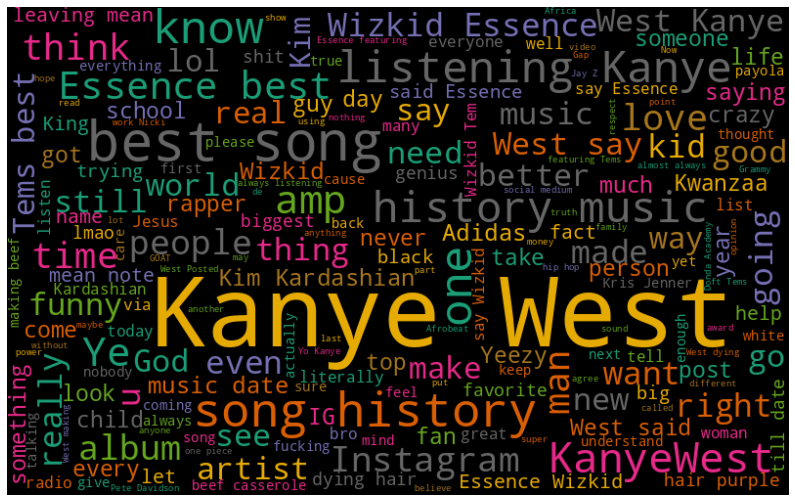

In [49]:
all_words = ' '.join([text for text in tweets_df['Clean_Clean_text'][tweets_df.sentiment == 'pos']])
generate_wordcloud(all_words)

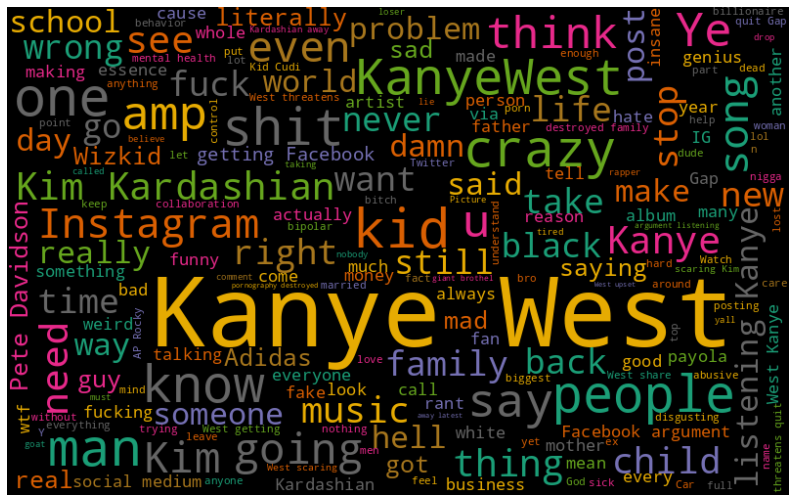

In [33]:
all_words = ' '.join([text for text in tweets_df['Clean_Clean_text'][tweets_df.sentiment == 'neg']])
generate_wordcloud(all_words)

In [34]:
# function to collect hashtags
def hashtag_extract(text_list):
    hashtags = []
    # Loop over the words in the tweet
    for text in text_list:
        ht = re.findall(r"#(\w+)", text)
        hashtags.append(ht)

    return hashtags

def generate_hashtag_freqdist(hashtags):
    a = nltk.FreqDist(hashtags)
    d = pd.DataFrame({'Hashtag': list(a.keys()),
                      'Count': list(a.values())})
    # selecting top 15 most frequent hashtags     
    d = d.nlargest(columns="Count", n = 25)
    plt.figure(figsize=(16,7))
    ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
    plt.xticks(rotation=80)
    ax.set(ylabel = 'Count')
    plt.show()

In [35]:
hashtags = hashtag_extract(tweets_df['Clean_text'])
hashtags = sum(hashtags, [])

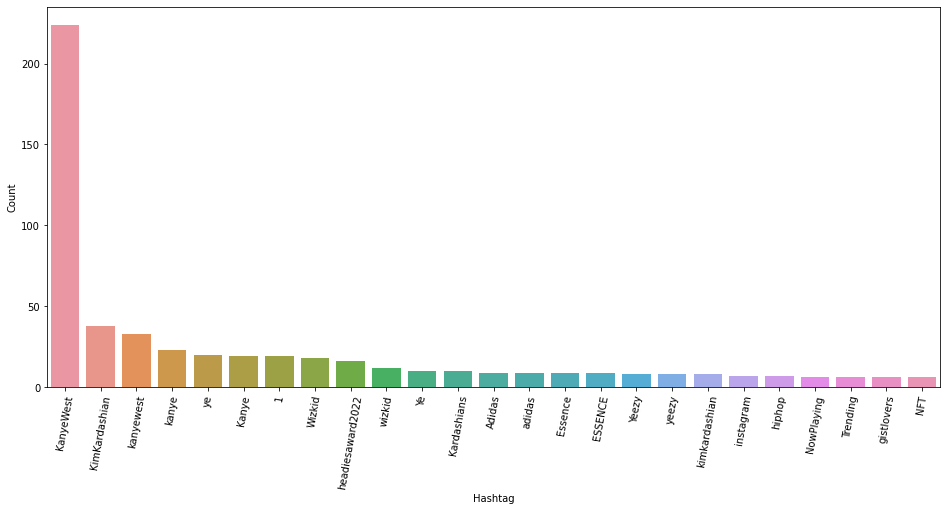

In [36]:
generate_hashtag_freqdist(hashtags)

In [37]:
# For sake of consistency, we are going to discard the records which contains no phrases i.e where tweets_df['key_phrases'] contains []
tweets_df2 = tweets_df[tweets_df['key_phrases'].str.len()>0]

In [38]:
# BOW features
bow_word_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
# bag-of-words feature matrix
bow_word_feature = bow_word_vectorizer.fit_transform(tweets_df2['Clean_Clean_text'])

# TF-IDF features
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
# TF-IDF feature matrix
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(tweets_df2['Clean_Clean_text'])

In [39]:
phrase_sents = tweets_df2['key_phrases'].apply(lambda x: ' '.join(x))

# BOW phrase features
bow_phrase_vectorizer = CountVectorizer(max_df=0.90, min_df=2)
bow_phrase_feature = bow_phrase_vectorizer.fit_transform(phrase_sents)

# TF-IDF phrase feature
tfidf_phrase_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2)
tfidf_phrase_feature = tfidf_phrase_vectorizer.fit_transform(phrase_sents)

## Model Building

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

Map target variables to {0, 1}


In [41]:
target_variable = tweets_df2['sentiment'].apply(lambda x: 0 if x=='neg' else 1)


In [42]:
def plot_confusion_matrix(matrix):
    plt.clf()
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Set2_r)
    classNames = ['Positive', 'Negative']
    plt.title('Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(matrix[i][j]))
    plt.show()

In [43]:
def naive_model(X_train, X_test, y_train, y_test):
    model = LogisticRegression(C=10,max_iter=1000).fit(X_train, y_train)

    # predictions over test set
    predictions = model.predict(X_test.toarray())
    # calculating Accuracy Score
    print(f'Accuracy Score - {accuracy_score(y_test, predictions)}')
    conf_matrix = confusion_matrix(y_test, predictions, labels=[True, False])
    plot_confusion_matrix(conf_matrix)

### Predictions on 'key words' based features

BOW word features

Accuracy Score - 0.8201174743024964


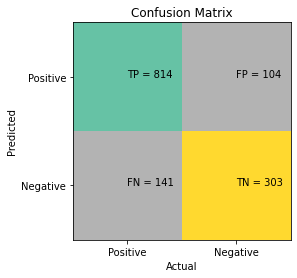

In [44]:
X_train, X_test, y_train, y_test = train_test_split(bow_word_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

TF-IDF word features

Accuracy Score - 0.8105726872246696


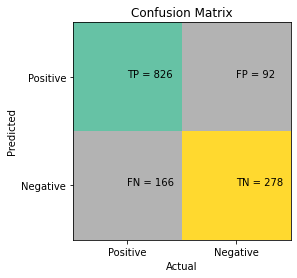

In [45]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_word_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

### Predictions on 'key phrases' based features

BOW word features

Accuracy Score - 0.7055800293685757


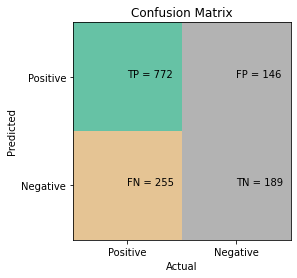

In [46]:
X_train, X_test, y_train, y_test = train_test_split(bow_phrase_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

TF-IDF word features

Accuracy Score - 0.7217327459618208


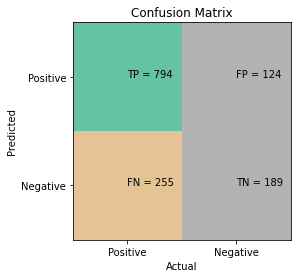

In [47]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_phrase_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

### Ressouces :
* kernels that will serve as a starting point of your journey

https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial
https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle
* If you want a more basic dataset to practice with here is another kernel 
https://www.kaggle.com/tanulsingh077/what-s-cooking
For Learning how to visualize test data and what to use view:
https://www.kaggle.com/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model
https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7b6b54b2-2213-42a8-9870-021e26f6311c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>